## 1. Покрытие генома

bwa index MG1655-K12.first10K.fasta

bwa mem MG1655-K12.first10K.fasta test_1.fastq > test_1.sam

samtools flagstat test_1.sam

samtools view -Sb test.sam > test.bam

samtools sort test.bam > test_sorted.bam

samtools depth test_sorted.bam > test_coverage.txt





Text(0.5, 1.0, 'Genome coverage')

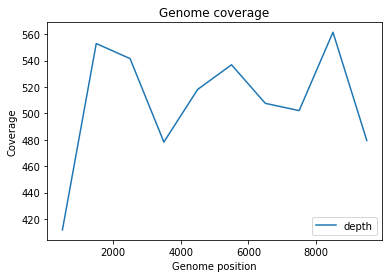

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("data/HW2/test/test_coverage.txt", sep="\t", usecols=[1,2], header=None)
df = df.rename(columns = {1: "genome_position", 2: "depth"})
df_averaged = df.groupby(np.arange(len(df))//1000).mean()

df_averaged.plot(x="genome_position", y="depth")
plt.ylabel("Coverage")
plt.xlabel("Genome position")
plt.title("Genome coverage")

In [39]:
print(f"Среднее покрытие: {int(df.depth.mean())}")
print(f"Доля покрытой области генома: {df.depth[df.depth>0].count()/len(df)*100}%")

Среднее покрытие: 508
Доля покрытой области генома: 100.0%


## 2. Распределение расстояния вставки

 samtools stats test_sorted.bam | grep ^IS | cut -f 2- > insertsizes.txt

Text(0.5, 1.0, 'Insert sizes distribution')

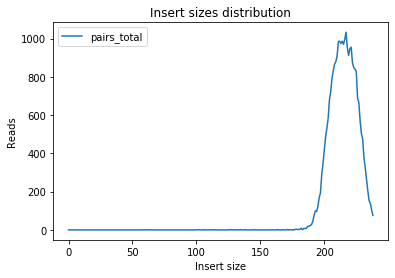

In [46]:
df = pd.read_csv("data/HW2/test/insertsizes.txt", sep="\t", usecols=[0,1], header=None)
df = df.rename(columns = {0: "insert_size", 1: "pairs_total"})
df.plot(x="insert_size", y="pairs_total")
plt.ylabel("Reads")
plt.xlabel("Insert size")
plt.title("Insert sizes distribution")

In [78]:
mean = (df.insert_size*df.pairs_total).sum()/df.pairs_total.sum()
print(f"Среднее расстояние вставки: {mean}")
std = np.sqrt(np.cov(df.insert_size, aweights=df.pairs_total))
print(f"Среднеквадратичное отклонение: {std}")

print(f"95% доверительный интервал: ({mean - 2*std}, {mean + 2*std})")


Среднее расстояние вставки: 215.07366838487974
Среднеквадратичное отклонение: 10.504082908706701
95% доверительный интервал: (194.06550256746632, 236.08183420229315)


## 3. Частоты различных замен